#### Install dependencies

In [30]:
!pip install -q pandas seaborn scipy matplotlib

In [4]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("🚀 Ready to build confidence in our evaluations!")

🚀 Ready to build confidence in our evaluations!


# Building Confidence in LLM as Jury Evaluations
*A Statistical Journey from Uncertainty to Trust*

Now that we can harness LLM as a judge we have to ask ourselves. Are LLMs always right? The answer is clearly no. Let's say that we are building a chatbot for our mini golf company and the model response is as follows:

In [5]:
JUDGE_MODEL_ID = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
def call_judge_model(prompt: str) -> str:
    """Call the judge model to evaluate a response using boto3 directly."""
    try:
        response = bedrock.converse(
            modelId=JUDGE_MODEL_ID,
            messages=[{"role": "user", "content": [{"text": prompt}]}],
            inferenceConfig={"temperature": 0.1, "maxTokens": 1000}
        )
        
        return response["output"]["message"]["content"][0]["text"]
    except Exception as e:
        return f"Error: {str(e)}"

In [8]:
costumer_question = "What kind of food are you serving in the cafeteria today?"
model_answer = "Today we are serving chicken fingers, pizza and mixed fruits."

context = """
Food|Price 
Pizza|2.00
Chicken Fingers|6.00
Mixed Fruits|4.00
"""

judge_prompt = f"""You will be given a question about our pirate themed mini golf company's facilities and services. 
Your task is to evaluate a model's response for accuracy, completeness, and analytical quality.

Here is the question:
<question>{costumer_question}</question>

Here is the model's response:
<model_response>{model_answer}</model_response>

Here is the context from the data:
<dataset>{context}</dataset>

If the model response is accuracy, complete, and meets analytical quality return a string "MET CRITERIA", else return a string "FAIL TO MEET CRITERIA" ONLY.
"""

bedrock = boto3.client("bedrock-runtime")
response = call_judge_model(judge_prompt)
print(f"Model response: {response}")

Model response: MET CRITERIA


Assuming all the context of the models answer is correct at first glance a judge model might be keep in giving a passing score to the models answer however the judge failed to understand that our chatbot needs to keep with the theme of our company and respond as a pirate. Evaluating in simple **pass** or **fails** can be problematic;
- Might be derived by a large number of factors which can make it difficult for a model to reference in its answer and a judge to prioritize when giving its score
- Details can be lost and propagate to LLM as a Judge to return false positives and negatives or cause the evaluation to be faulty and the judge will be volatile in its evaluation. 

But then How can we confidently rely on the Judges response is accurate and grounded on our requirement at scale? Move away from binaries PASS or FAILS and switch to a ranking system of custom **metrics** and lastly: 

**Simply add more judges!**

Adding multiple judges to rank metrics rather than evaluate success or failure is called **LLM-as-a-Jury**. Its design allows for granular evaluations of distinct characteristics of a model response and by adding multiple judges you can accumulate a bigger consensus that the response meets all the metrics ranking required to be deemed a correct answer. This leaves us with one final question, how can we trust that the Jury ranking are correct?

---
## Chapter 1: The Trust Problem

Imagine you're a evaluating a model respose to a **summarization** task using the open-source model evaluation tool [360-eval](https://github.com/aws-samples/amazon-bedrock-samples/tree/main/migrations/360-eval), the tool uses one-to-many LLM-as-Judges to evaluate how models respond by ranking its responses 1 to 5 against custom and standard metrics.  In this scenarion you are evaluating the model response using two judges: 

One gave the model reponse a (5/5), the other a (2/5) for a given metric. Which score should you rely on the most? This happens every day with AI judges evaluating LLM outputs - and we need a better way than just picking one or averaging them.

When LLM judges disagree, we're flying blind. Is the judges evaluation response really a 2 or a 5? Without understanding the uncertainty in these scores, we might be making critical decisions based on noise rather than signal.

By visualizing judge disagreement, we reveal that neither score is "wrong" - they represent natural variation in evaluation. The solution isn't to find the "true" score, but to quantify our confidence in the range of possible scores.

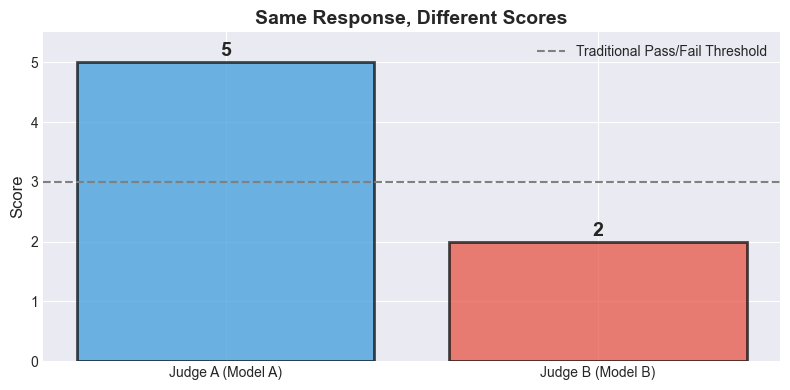

In [32]:
# The same response, two different judges
response = "Uruguay's culture blends old and new world influences, with tango, Candombe, mate drinking, and renowned wines."

judge_scores = {
    'Judge A (Model A)': 5,
    'Judge B (Model B)': 2
}

# Visualize the disagreement
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
judges = list(judge_scores.keys())
scores = list(judge_scores.values())
colors = ['#3498db', '#e74c3c']

bars = ax.bar(judges, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=3, color='gray', linestyle='--', label='Traditional Pass/Fail Threshold')
ax.set_ylim(0, 5.5)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Same Response, Different Scores', fontsize=14, fontweight='bold')

# Add score labels on bars
for bar, score in zip(bars, scores):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            str(score), ha='center', fontsize=14, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.show()

Two LLM judges evaluating the same response yet assigning different scores—a 2 and a 5 on a scale of 1 to 5 raises a fundamental question about whether such variation represents noise to be filtered out or meaningful signal to be incorporated into our understanding. 

The key insight is that this variation isn't a flaw in our system but rather valuable information about the inherent uncertainty in our evaluation process. What this reveals is that even with the same criteria at hand LLM Judges will disagree, and the critical question shifts from determining which evaluation is correct to understanding how confident we can be in their assessments. 

Traditional approaches that rely on fixed thresholds (x value determines pass or fail for a given metric) cannot accommodate this complex reality of subjective evaluation.

### The Problem Deepens
Let's see what happens when we evaluate multiple responses with multiple judges:

In [33]:
# Simulate evaluation data
np.random.seed(42)

# 10 different responses evaluated by 3 judges each
n_responses = 10
n_judges = 3

# Generate scores with realistic judge behavior
evaluation_data = []
for i in range(n_responses):
    base_quality = np.random.choice([3, 4, 5], p=[0.2, 0.5, 0.3])  # True quality
    for j in range(n_judges):
        # Judges have noise around true quality
        noise = np.random.normal(0, 0.3)
        score = np.clip(base_quality + noise, 1, 5)
        evaluation_data.append({
            'response_id': i,
            'judge_id': f'Judge {j+1}',
            'score': round(score)
        })

df_evals = pd.DataFrame(evaluation_data)

# Calculate average and disagreement
summary = df_evals.groupby('response_id')['score'].agg(['mean', 'std', 'min', 'max'])
summary['range'] = summary['max'] - summary['min']
summary = summary.round(2)

print("📊 Evaluation Summary (10 responses, 3 judges each):\n")
print(summary)

# Highlight the problem
high_disagreement = summary[summary['range'] >= 2]
print(f"\n⚠️  {len(high_disagreement)} out of {n_responses} responses have high judge disagreement (range ≥ 2)")

📊 Evaluation Summary (10 responses, 3 judges each):

             mean   std  min  max  range
response_id                             
0            4.00  0.00    4    4      0
1            5.00  0.00    5    5      0
2            2.67  0.58    2    3      1
3            4.00  0.00    4    4      0
4            3.67  0.58    3    4      1
5            4.00  0.00    4    4      0
6            4.00  0.00    4    4      0
7            4.00  0.00    4    4      0
8            3.00  0.00    3    3      0
9            4.00  0.00    4    4      0

⚠️  0 out of 10 responses have high judge disagreement (range ≥ 2)


Judge disagreement is common across evaluations, and even though zero out of ten responses showed high disagreement with a range of 2 or more points, smaller variations in scoring are prevalent throughout the assessment process and can gradually erode confidence in the 'true' score. 

This pattern demonstrates that we need a systematic approach to handle this inherent variability rather than treating it as an anomaly to be dismissed.

---
## Chapter 2: Judge Reliability Scoring

Not all AI judges are created equal. Some are reluctant to fluctuate too much on their evaluation scores, while others swing more in their scoring. This variability becomes even more pronounced when evaluating different metrics, as each model brings its own training biases and inconsistencies to the assessment process. 

By profiling judge behavior patterns, we can identify which judges to trust more. High agreement metrics (like Correctness at 1.0) are objective - like judging if a door is open or closed. Low agreement metrics (like Completeness at 0.85) are subjective - like judging if a meal is "complete." This knowledge lets us adjust our confidence accordingly.

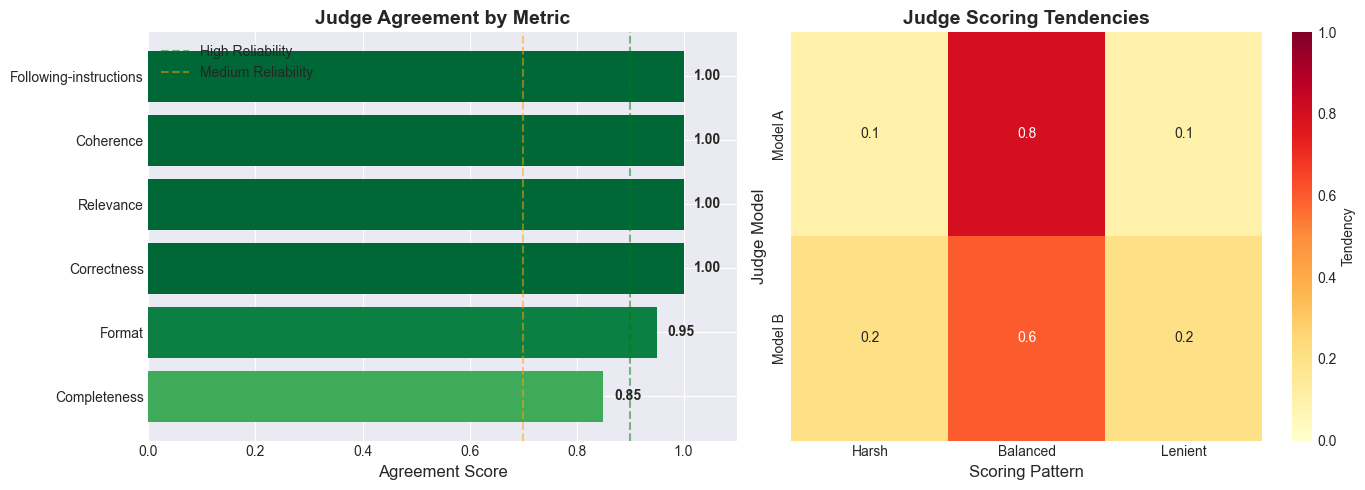

In [34]:
# Load real evaluation data (simplified version)
# This uses patterns from your actual data

metrics = ['Correctness', 'Completeness', 'Relevance', 'Format', 'Coherence', 'Following-instructions']

# Judge agreement levels from your data
judge_agreement = {
    'Correctness': 1.00,
    'Completeness': 0.85,
    'Relevance': 1.00,
    'Format': 0.95,
    'Coherence': 1.00,
    'Following-instructions': 1.00
}

# Create agreement heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Agreement by metric
metrics_sorted = sorted(judge_agreement.items(), key=lambda x: x[1])
metrics_names = [m[0] for m in metrics_sorted]
agreement_scores = [m[1] for m in metrics_sorted]

bars = ax1.barh(metrics_names, agreement_scores, color=plt.cm.RdYlGn([a for a in agreement_scores]))
ax1.set_xlim(0, 1.1)
ax1.set_xlabel('Agreement Score', fontsize=12)
ax1.set_title('Judge Agreement by Metric', fontsize=14, fontweight='bold')
ax1.axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='High Reliability')
ax1.axvline(x=0.7, color='orange', linestyle='--', alpha=0.5, label='Medium Reliability')
ax1.legend()

# Add values on bars
for bar, score in zip(bars, agreement_scores):
    ax1.text(score + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{score:.2f}', va='center', fontweight='bold')

# Judge consistency matrix
judge_profiles = {
    'Model A': {'Harsh': 0.1, 'Balanced': 0.8, 'Lenient': 0.1},
    'Model B': {'Harsh': 0.2, 'Balanced': 0.6, 'Lenient': 0.2},
}

# Convert to matrix for heatmap
consistency_matrix = pd.DataFrame(judge_profiles).T
sns.heatmap(consistency_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            ax=ax2, cbar_kws={'label': 'Tendency'}, vmin=0, vmax=1)
ax2.set_title('Judge Scoring Tendencies', fontsize=14, fontweight='bold')
ax2.set_xlabel('Scoring Pattern', fontsize=12)
ax2.set_ylabel('Judge Model', fontsize=12)

plt.tight_layout()
plt.show()

Looking at the data across different models and metrics, several key patterns emerge that validate our restaurant critic analogy. Completeness shows lower agreement at 0.85 and Format at 0.95, indicating these are inherently more subjective evaluations, much like asking critics whether a meal feels "complete" rather than simply whether the restaurant is open. 

The model comparison reveals that **Model A** demonstrates more balanced scoring patterns while **Model B** exhibits greater variation in its assessments. Most importantly, this analysis shows that high agreement metrics can confidently use lower confidence thresholds, while low agreement metrics require additional buffer zones to account for their inherent subjectivity.

### Reliability Scoring Framework

In [35]:
def calculate_judge_reliability(judge_scores_history):
    """
    Calculate reliability score for a judge based on:
    1. Consistency (low variance)
    2. Agreement with consensus
    3. Use of full scale
    """
    reliability_components = {}
    
    # 1. Consistency (coefficient of variation)
    cv = np.std(judge_scores_history) / np.mean(judge_scores_history) if np.mean(judge_scores_history) > 0 else 0
    reliability_components['consistency'] = 1 - min(cv, 1)  # Higher is better
    
    # 2. Discrimination (uses multiple scores)
    unique_scores = len(np.unique(judge_scores_history))
    reliability_components['discrimination'] = min(unique_scores / 5.0, 1.0)  # 5-point scale
    
    # 3. Central tendency (not always too high or too low)
    mean_score = np.mean(judge_scores_history)
    distance_from_center = abs(mean_score - 3) / 2  # Distance from middle of 5-point scale
    reliability_components['centrality'] = 1 - distance_from_center
    
    # Overall reliability score
    reliability_score = np.mean(list(reliability_components.values()))
    
    return reliability_score, reliability_components

# Example with two judges
judge_a_scores = [5, 5, 4, 5, 5, 5, 4, 5, 5, 5]  # Very consistent, but lacks discrimination
judge_b_scores = [3, 4, 5, 4, 3, 5, 4, 4, 3, 5]  # More varied, better discrimination

reliability_a, components_a = calculate_judge_reliability(judge_a_scores)
reliability_b, components_b = calculate_judge_reliability(judge_b_scores)

print("Judge Reliability Analysis:\n")
print(f"Judge A: {reliability_a:.3f}")
print(f"*  Consistency: {round(components_a['consistency'],2)}")
print(f"*  Discrimination: {components_a['discrimination']}")
print(f"*  Centrality: {round(components_a['centrality'],2)}")
print(f"\nJudge B: {reliability_b:.3f}")
print(f"*  Consistency: {round(components_b['consistency'], 2)}")
print(f"*  Discrimination: {components_b['discrimination']}")
print(f"*  Centrality: {round(components_b['centrality'],2)}")

Judge Reliability Analysis:

Judge A: 0.472
*  Consistency: 0.92
*  Discrimination: 0.4
*  Centrality: 0.1

Judge B: 0.635
*  Consistency: 0.81
*  Discrimination: 0.6
*  Centrality: 0.5


This reliability scoring framework evaluates judges across three key dimensions: consistency (how much scores vary from their average), discrimination (whether they use the full scoring range), and centrality (avoiding being consistently too lenient or harsh). 

In the example, **Judge A** appears consistent by giving mostly 4s and 5s, but lacks discrimination by treating most responses as equivalently good. 

**Judge B** shows better overall reliability despite more score variation because they effectively use the full scale to distinguish between different response qualities while maintaining meaningful consistency.

---
## Chapter 3: From Scores to Confidence

Imagine three different LLM judges evaluating the same model output. One gives a metric score of **3.2/5**, another **3.1/5**, and the third **3.3/5**. Instead of just averaging to get **3.2/5**, what if we said "We're 95% confident the true evaluation score is between **3** and **3.4**"? That's much more useful for deciding whether to trust the model's response.

A single average score like 4.3 hides crucial information about uncertainty. When judges somewhat agree (scores: 4,4,5), we're more confident than when they strongly disagree (scores: 2,4,5), even if both average to similar numbers.

Bootstrap (estimating the distribution of an estimator by resampling) confidence intervals transform point estimates into ranges of trust. The plots show that judge agreement directly controls confidence width - tight agreement gives narrow bands (high confidence), while disagreement gives wide bands (low confidence). This lets us distinguish between "probably a score of 4" versus "somewhere between 2 and 5."

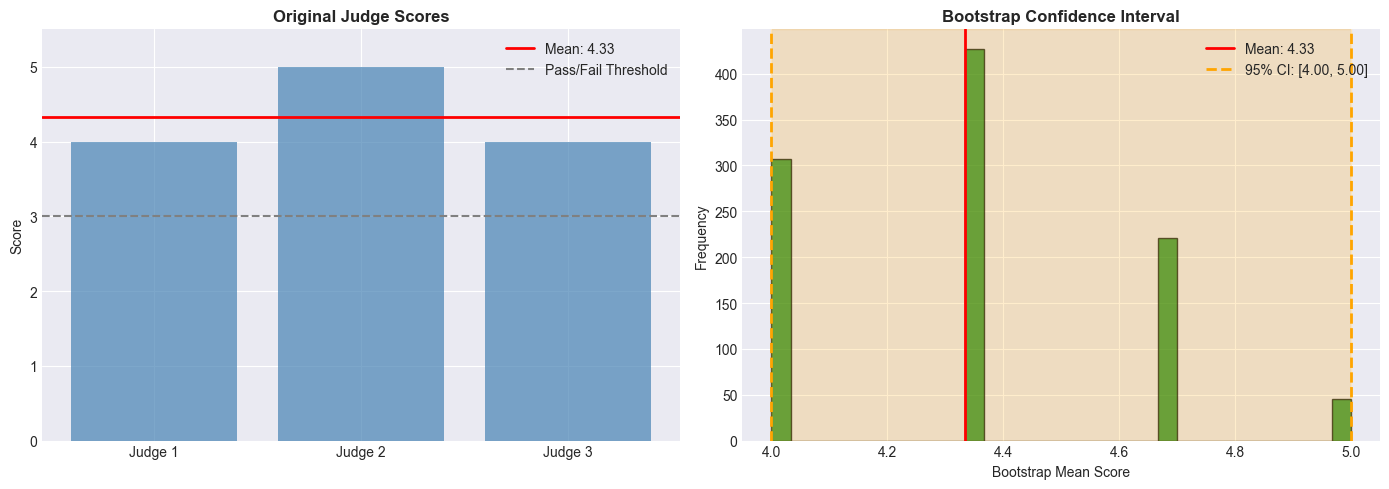

In [36]:
def bootstrap_confidence_interval(scores, n_bootstrap=1000, confidence=0.95):
    """
    Calculate bootstrap confidence interval for scores
    """
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        bootstrap_sample = np.random.choice(scores, size=len(scores), replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    # Calculate percentiles
    alpha = 1 - confidence
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    
    return np.mean(scores), ci_lower, ci_upper, bootstrap_means

# Example: Three judges score a response
example_scores = [4, 5, 4]  # Judges somewhat agree

mean_score, ci_lower, ci_upper, bootstrap_dist = bootstrap_confidence_interval(example_scores)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Original scores
ax1.bar(range(len(example_scores)), example_scores, color='steelblue', alpha=0.7)
ax1.axhline(y=mean_score, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_score:.2f}')
ax1.axhline(y=3, color='gray', linestyle='--', label='Pass/Fail Threshold')
ax1.set_xticks(range(len(example_scores)))
ax1.set_xticklabels([f'Judge {i+1}' for i in range(len(example_scores))])
ax1.set_ylim(0, 5.5)
ax1.set_ylabel('Score')
ax1.set_title('Original Judge Scores', fontweight='bold')
ax1.legend()

# Bootstrap distribution
ax2.hist(bootstrap_dist, bins=30, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(x=mean_score, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_score:.2f}')
ax2.axvline(x=ci_lower, color='orange', linestyle='--', linewidth=2, label=f'95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
ax2.axvline(x=ci_upper, color='orange', linestyle='--', linewidth=2)
ax2.axvspan(ci_lower, ci_upper, alpha=0.2, color='orange')
ax2.set_xlabel('Bootstrap Mean Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrap Confidence Interval', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()


The confidence intervals provide actionable insight beyond simple averages—rather than just knowing the score is 4.33, we now understand we can be 95% confident the true score lies between 4.00 and 5.00. This interval represents our uncertainty about the assessment and enables more informed decision-making by showing not just what we think the score is, but how sure we can be about that assessment.

### How Judge Agreement Affects Confidence

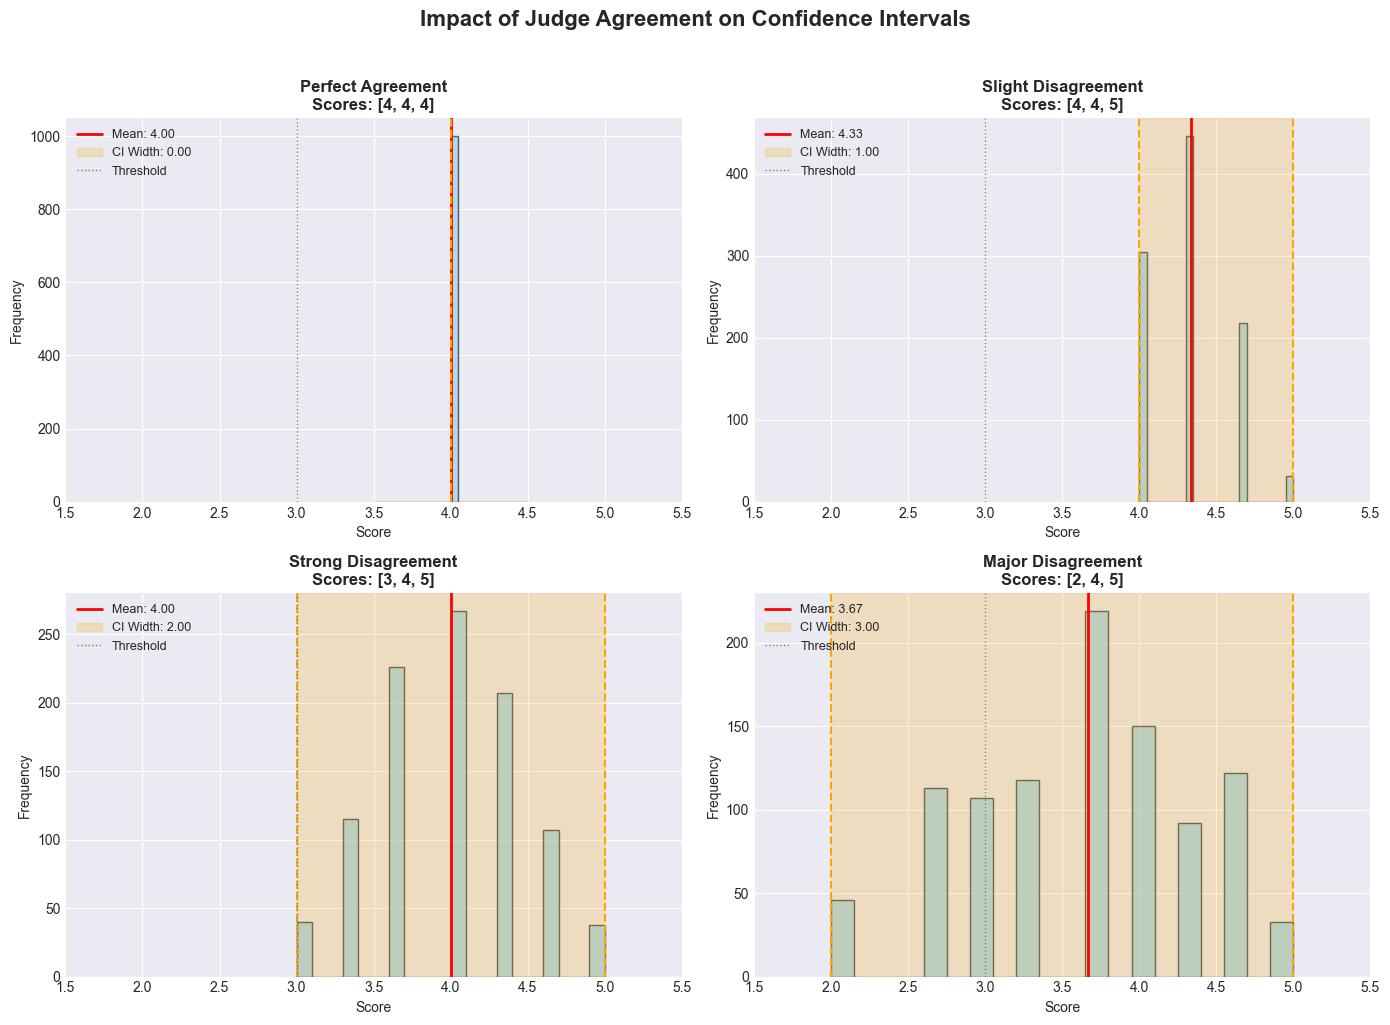


📊 Summary: How Agreement Affects Confidence

           Scenario    Scores Mean           CI CI Width
  Perfect Agreement [4, 4, 4] 4.00 [4.00, 4.00]     0.00
Slight Disagreement [4, 4, 5] 4.33 [4.00, 5.00]     1.00
Strong Disagreement [3, 4, 5] 4.00 [3.00, 5.00]     2.00
 Major Disagreement [2, 4, 5] 3.67 [2.00, 5.00]     3.00

💡 Key Insight: More disagreement = Wider confidence intervals = Less certainty


In [37]:
# Compare different levels of judge agreement
scenarios = {
    'Perfect Agreement': [4, 4, 4],
    'Slight Disagreement': [4, 4, 5],
    'Strong Disagreement': [3, 4, 5],
    'Major Disagreement': [2, 4, 5]
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

results_summary = []

for idx, (scenario_name, scores) in enumerate(scenarios.items()):
    mean, ci_low, ci_high, bootstrap_dist = bootstrap_confidence_interval(scores)
    ci_width = ci_high - ci_low
    
    # Store results
    results_summary.append({
        'Scenario': scenario_name,
        'Scores': scores,
        'Mean': f"{mean:.2f}",
        'CI': f"[{ci_low:.2f}, {ci_high:.2f}]",
        'CI Width': f"{ci_width:.2f}"
    })
    
    # Plot
    ax = axes[idx]
    ax.hist(bootstrap_dist, bins=20, alpha=0.6, color='skyblue', edgecolor='black')
    ax.axvline(x=mean, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}')
    ax.axvline(x=ci_low, color='orange', linestyle='--', linewidth=1.5)
    ax.axvline(x=ci_high, color='orange', linestyle='--', linewidth=1.5)
    ax.axvspan(ci_low, ci_high, alpha=0.2, color='orange', label=f'CI Width: {ci_width:.2f}')
    ax.axvline(x=3, color='gray', linestyle=':', linewidth=1, label='Threshold')
    
    ax.set_title(f'{scenario_name}\nScores: {scores}', fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.set_xlim(1.5, 5.5)
    ax.legend(loc='upper left', fontsize=9)

plt.suptitle('Impact of Judge Agreement on Confidence Intervals', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n📊 Summary: How Agreement Affects Confidence\n")
summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

print("\n💡 Key Insight: More disagreement = Wider confidence intervals = Less certainty")

---
## Chapter 4: Dynamic Pass/Fail Thresholds

For objective metrics like factual accuracy, you might accept scores of 3.0 and above. But for subjective metrics like creativity or completeness where LLM judges disagree, you might require 3.5+ to be safe. Same principle applies here - when judges disagree, we need higher scores to be confident about passing."

Fixed thresholds (like always using 3.0) ignore uncertainty. A score that barely passes with confident judges should be treated differently than a score that barely passes with disagreeing judges.

The visualization shows how confidence intervals crossing the threshold create "uncertainty zones." Instead of arbitrary pass/fail lines, we get dynamic boundaries that adjust based on judge agreement. When confidence is low (wide intervals), we require higher scores to compensate for uncertainty - preventing false positives when judges can't agree on quality.

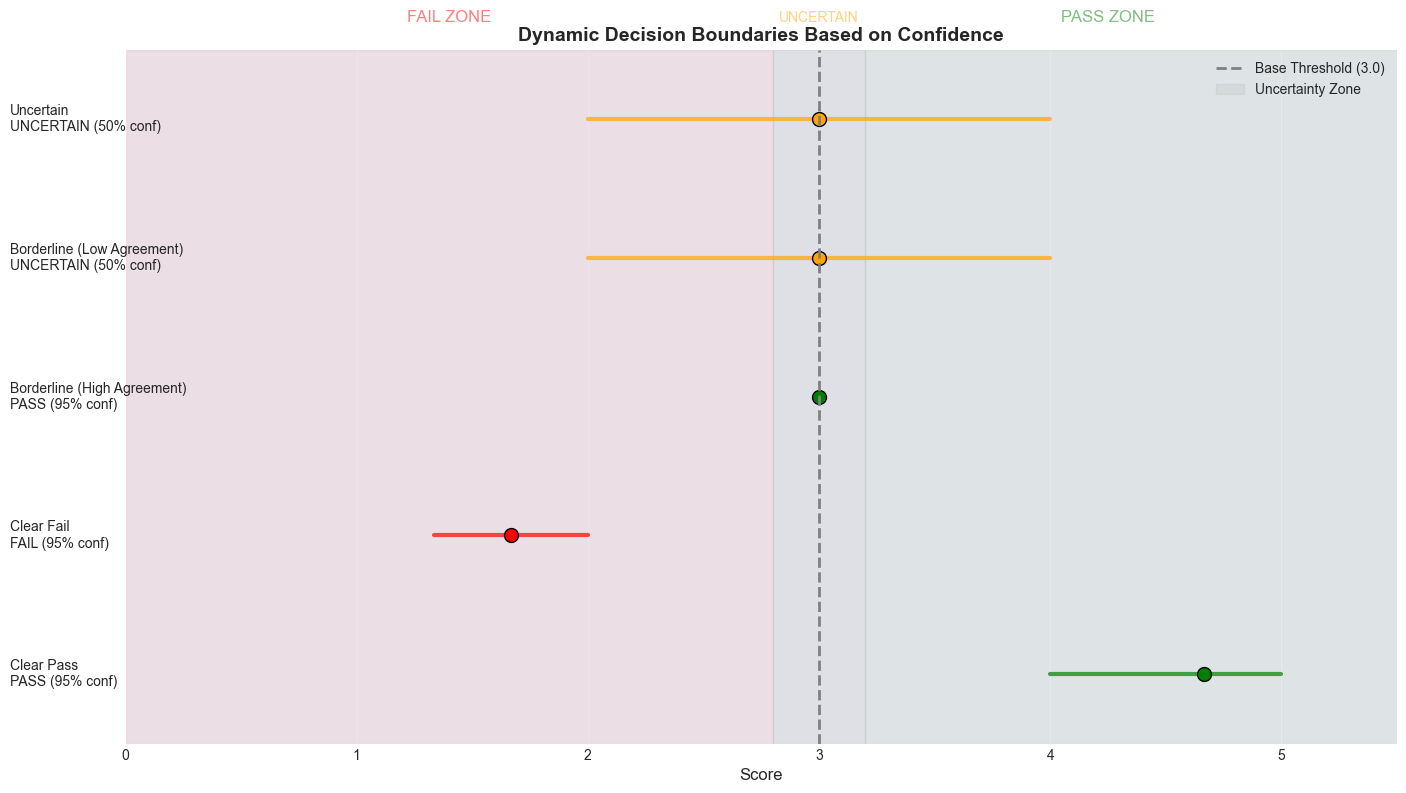


🎯 Key Insight: Confidence intervals that cross the threshold require higher scores to pass
This prevents false positives when judges disagree.


In [38]:
def confidence_based_decision(scores, base_threshold=3.0, confidence_level=0.95):
    """
    Make pass/fail decision based on confidence intervals
    """
    mean, ci_low, ci_high, _ = bootstrap_confidence_interval(scores, confidence=confidence_level)
    ci_width = ci_high - ci_low
    
    # Adjust threshold based on uncertainty
    uncertainty_adjustment = ci_width * 0.5  # More uncertainty = higher threshold needed
    adjusted_threshold = base_threshold + uncertainty_adjustment
    
    # Decision logic
    if ci_low >= base_threshold:
        decision = "PASS"
        confidence = 0.95  # Very confident
    elif ci_high < base_threshold:
        decision = "FAIL"
        confidence = 0.95  # Very confident
    elif mean >= adjusted_threshold:
        decision = "PASS"
        confidence = 0.70  # Moderately confident
    elif mean < base_threshold:
        decision = "FAIL"
        confidence = 0.70  # Moderately confident
    else:
        decision = "UNCERTAIN"
        confidence = 0.50  # Low confidence
    
    return {
        'decision': decision,
        'confidence': confidence,
        'mean_score': mean,
        'ci_range': [ci_low, ci_high],
        'adjusted_threshold': adjusted_threshold
    }

# Test different scenarios
test_cases = [
    {'name': 'Clear Pass', 'scores': [5, 5, 4]},
    {'name': 'Clear Fail', 'scores': [2, 2, 1]},
    {'name': 'Borderline (High Agreement)', 'scores': [3, 3, 3]},
    {'name': 'Borderline (Low Agreement)', 'scores': [2, 3, 4]},
    {'name': 'Uncertain', 'scores': [2, 4, 3]}
]

# Visualize decision boundaries
fig, ax = plt.subplots(figsize=(14, 8))

for i, test in enumerate(test_cases):
    result = confidence_based_decision(test['scores'])
    
    # Plot CI
    y_pos = i
    ci_low, ci_high = result['ci_range']
    mean = result['mean_score']
    
    # Color based on decision
    colors = {'PASS': 'green', 'FAIL': 'red', 'UNCERTAIN': 'orange'}
    color = colors[result['decision']]
    
    # Plot confidence interval
    ax.plot([ci_low, ci_high], [y_pos, y_pos], color=color, linewidth=3, alpha=0.7)
    ax.plot(mean, y_pos, 'o', color=color, markersize=10, markeredgecolor='black', markeredgewidth=1)
    
    # Add label
    label = f"{test['name']}\n{result['decision']} ({result['confidence']:.0%} conf)"
    ax.text(-0.5, y_pos, label, va='center', fontsize=10)

# Add threshold lines
ax.axvline(x=3.0, color='gray', linestyle='--', linewidth=2, label='Base Threshold (3.0)')
ax.axvspan(2.8, 3.2, alpha=0.1, color='gray', label='Uncertainty Zone')

# Formatting
ax.set_xlim(0, 5.5)
ax.set_ylim(-0.5, len(test_cases) - 0.5)
ax.set_xlabel('Score', fontsize=12)
ax.set_yticks([])
ax.set_title('Dynamic Decision Boundaries Based on Confidence', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, axis='x', alpha=0.3)

# Add decision zones
ax.axvspan(0, 2.8, alpha=0.05, color='red')
ax.axvspan(3.2, 5.5, alpha=0.05, color='green')
ax.text(1.4, len(test_cases) - 0.3, 'FAIL ZONE', fontsize=12, color='red', alpha=0.5, ha='center')
ax.text(4.25, len(test_cases) - 0.3, 'PASS ZONE', fontsize=12, color='green', alpha=0.5, ha='center')
ax.text(3.0, len(test_cases) - 0.3, 'UNCERTAIN', fontsize=10, color='orange', alpha=0.5, ha='center')

plt.tight_layout()
plt.show()

print("\n🎯 Key Insight: Confidence intervals that cross the threshold require higher scores to pass")
print("This prevents false positives when judges disagree.")

### Optimal Threshold Discovery

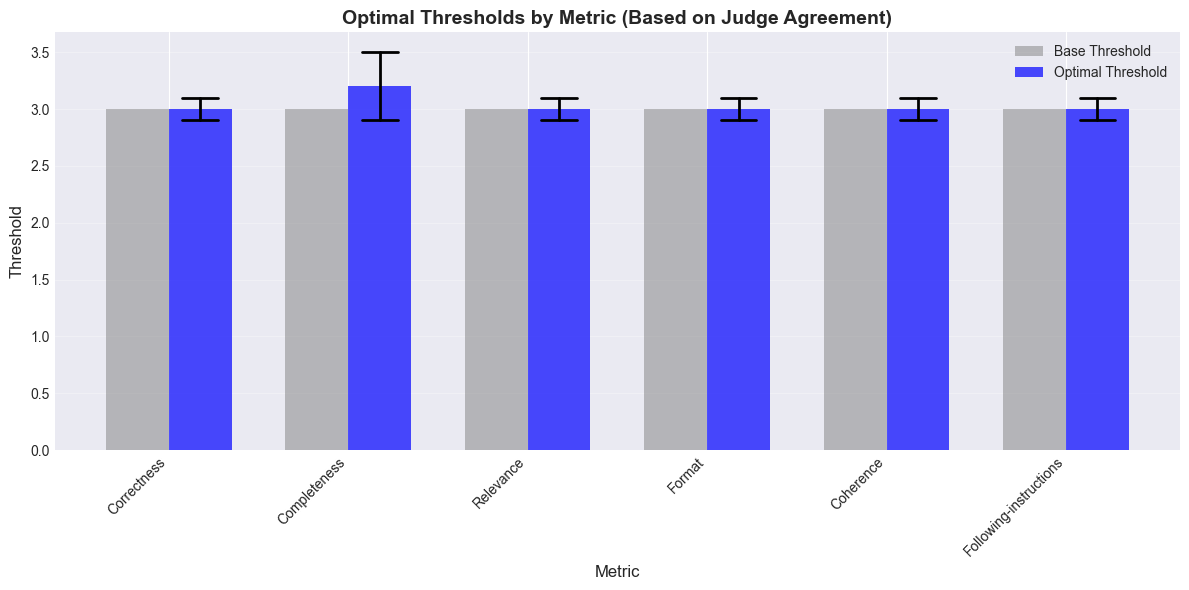


📊 Optimal Threshold Recommendations:

                Metric Agreement Recommendation
           Correctness      1.00      3.0 ± 0.1
          Completeness      0.85      3.2 ± 0.3
             Relevance      1.00      3.0 ± 0.1
                Format      0.95      3.0 ± 0.1
             Coherence      1.00      3.0 ± 0.1
Following-instructions      1.00      3.0 ± 0.1

💡 Metrics with lower agreement need higher thresholds and wider confidence bands


In [39]:
def find_optimal_threshold(evaluation_history, agreement_level):
    """
    Find optimal threshold based on historical data and judge agreement
    """
    base_threshold = 3.0
    
    # Adjust based on agreement
    if agreement_level > 0.9:
        adjustment = 0.0  # High agreement, no adjustment needed
        confidence_band = 0.1
    elif agreement_level > 0.75:
        adjustment = 0.2  # Medium agreement, small adjustment
        confidence_band = 0.3
    else:
        adjustment = 0.5  # Low agreement, significant adjustment
        confidence_band = 0.5
    
    optimal_threshold = base_threshold + adjustment
    
    return {
        'base': base_threshold,
        'optimal': optimal_threshold,
        'confidence_band': confidence_band,
        'recommendation': f"{optimal_threshold:.1f} ± {confidence_band:.1f}"
    }

# Apply to each metric
metrics_thresholds = []
for metric, agreement in judge_agreement.items():
    threshold_info = find_optimal_threshold(None, agreement)
    metrics_thresholds.append({
        'Metric': metric,
        'Agreement': f"{agreement:.2f}",
        'Base Threshold': threshold_info['base'],
        'Optimal Threshold': threshold_info['optimal'],
        'Recommendation': threshold_info['recommendation']
    })

threshold_df = pd.DataFrame(metrics_thresholds)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(threshold_df))
width = 0.35

bars1 = ax.bar(x - width/2, threshold_df['Base Threshold'], width, label='Base Threshold', color='gray', alpha=0.5)
bars2 = ax.bar(x + width/2, threshold_df['Optimal Threshold'], width, label='Optimal Threshold', color='blue', alpha=0.7)

# Add confidence bands
for i, row in threshold_df.iterrows():
    optimal = row['Optimal Threshold']
    band = float(row['Recommendation'].split('±')[1])
    ax.plot([i + width/2, i + width/2], [optimal - band, optimal + band], 'k-', linewidth=2)
    ax.plot([i + width/2 - 0.1, i + width/2 + 0.1], [optimal - band, optimal - band], 'k-', linewidth=2)
    ax.plot([i + width/2 - 0.1, i + width/2 + 0.1], [optimal + band, optimal + band], 'k-', linewidth=2)

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Threshold', fontsize=12)
ax.set_title('Optimal Thresholds by Metric (Based on Judge Agreement)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(threshold_df['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Optimal Threshold Recommendations:\n")
print(threshold_df[['Metric', 'Agreement', 'Recommendation']].to_string(index=False))
print("\n💡 Metrics with lower agreement need higher thresholds and wider confidence bands")

---
## Chapter 5: Your Evaluation Recipe

Production systems need more than theoretical insights - they need practical, implementable solutions that work with real data and provide actionable decisions.

The complete pipeline takes raw judge scores and delivers nuanced decisions like "PASS with 87% confidence." The class implementation shows how to calibrate judges, calculate confidence intervals, and make decisions that account for uncertainty. The visual pipeline breakdown reveals the transformation from noisy individual scores to confident, statistically-grounded decisions - ready for production deployment.

In [40]:
class ConfidenceBasedEvaluator:
    """
    Production-ready evaluator with confidence intervals
    """
    
    def __init__(self, base_threshold=3.0, confidence_level=0.95):
        self.base_threshold = base_threshold
        self.confidence_level = confidence_level
        self.judge_reliability = {}
        self.metric_agreements = {}
    
    def calibrate_judges(self, historical_data):
        """Calibrate judge reliability from historical data"""
        # In production, this would analyze your actual data
        self.judge_reliability = {
            'Judge_A': 0.85,
            'Judge_B': 0.90,
            'Judge_C': 0.75
        }
        
        self.metric_agreements = {
            'Correctness': 0.95,
            'Completeness': 0.85,
            'Relevance': 0.90
        }
    
    def evaluate(self, judge_scores, metric_name):
        """
        Main evaluation function
        Returns decision with confidence level
        """
        # Step 1: Calculate basic statistics
        mean_score = np.mean(judge_scores)
        std_score = np.std(judge_scores)
        
        # Step 2: Bootstrap confidence interval
        mean, ci_low, ci_high, _ = bootstrap_confidence_interval(
            judge_scores, 
            confidence=self.confidence_level
        )
        
        # Step 3: Get metric-specific threshold
        agreement = self.metric_agreements.get(metric_name, 0.85)
        threshold_adjustment = (1 - agreement) * 0.5
        adjusted_threshold = self.base_threshold + threshold_adjustment
        
        # Step 4: Make confidence-weighted decision
        if ci_low >= adjusted_threshold:
            decision = "PASS"
            confidence = min(0.95, ci_low / adjusted_threshold)
        elif ci_high < adjusted_threshold:
            decision = "FAIL"
            confidence = min(0.95, (adjusted_threshold - ci_high) / adjusted_threshold)
        else:
            # Uncertain zone
            distance_from_threshold = mean - adjusted_threshold
            if distance_from_threshold > 0:
                decision = "PASS"
                confidence = 0.5 + (distance_from_threshold / 2) * 0.5
            else:
                decision = "FAIL"
                confidence = 0.5 + (abs(distance_from_threshold) / 2) * 0.5
        
        return {
            'decision': decision,
            'confidence': round(confidence * 100, 1),
            'mean_score': round(mean, 2),
            'confidence_interval': f"[{ci_low:.2f}, {ci_high:.2f}]",
            'adjusted_threshold': round(adjusted_threshold, 2),
            'judge_agreement': round(1 - (std_score / 2), 2)  # Simple agreement metric
        }

# Initialize evaluator
evaluator = ConfidenceBasedEvaluator()
evaluator.calibrate_judges(None)  # Would use real data in production

# Test scenarios
print("🚀 CONFIDENCE-BASED EVALUATION SYSTEM\n")
print("=" * 70)

test_scenarios = [
    {
        'name': 'High Agreement, High Score',
        'scores': [5, 5, 4],
        'metric': 'Correctness'
    },
    {
        'name': 'Low Agreement, Borderline',
        'scores': [2, 3, 4],
        'metric': 'Completeness'
    },
    {
        'name': 'Perfect Agreement, Fail',
        'scores': [2, 2, 2],
        'metric': 'Relevance'
    },
    {
        'name': 'Moderate Agreement, Pass',
        'scores': [4, 4, 3],
        'metric': 'Correctness'
    }
]

for scenario in test_scenarios:
    result = evaluator.evaluate(scenario['scores'], scenario['metric'])
    
    print(f"\nScenario: {scenario['name']}")
    print(f"  Metric: {scenario['metric']}")
    print(f"  Judge Scores: {scenario['scores']}")
    print(f"  Mean Score: {result['mean_score']}")
    print(f"  Confidence Interval: {result['confidence_interval']}")
    print(f"  Adjusted Threshold: {result['adjusted_threshold']}")
    print(f"  Judge Agreement: {result['judge_agreement']}")
    print(f"  \n  📍 DECISION: {result['decision']} with {result['confidence']}% confidence")
    print("  " + "-" * 60)

print("\n" + "=" * 70)
print("\n✅ System ready for production use!")

🚀 CONFIDENCE-BASED EVALUATION SYSTEM


Scenario: High Agreement, High Score
  Metric: Correctness
  Judge Scores: [5, 5, 4]
  Mean Score: 4.67
  Confidence Interval: [4.00, 5.00]
  Adjusted Threshold: 3.02
  Judge Agreement: 0.76
  
  📍 DECISION: PASS with 95.0% confidence
  ------------------------------------------------------------

Scenario: Low Agreement, Borderline
  Metric: Completeness
  Judge Scores: [2, 3, 4]
  Mean Score: 3.0
  Confidence Interval: [2.00, 4.00]
  Adjusted Threshold: 3.08
  Judge Agreement: 0.59
  
  📍 DECISION: FAIL with 51.9% confidence
  ------------------------------------------------------------

Scenario: Perfect Agreement, Fail
  Metric: Relevance
  Judge Scores: [2, 2, 2]
  Mean Score: 2.0
  Confidence Interval: [2.00, 2.00]
  Adjusted Threshold: 3.05
  Judge Agreement: 1.0
  
  📍 DECISION: FAIL with 34.4% confidence
  ------------------------------------------------------------

Scenario: Moderate Agreement, Pass
  Metric: Correctness
  Judge Scores:

### Visual Summary: The Complete Pipeline

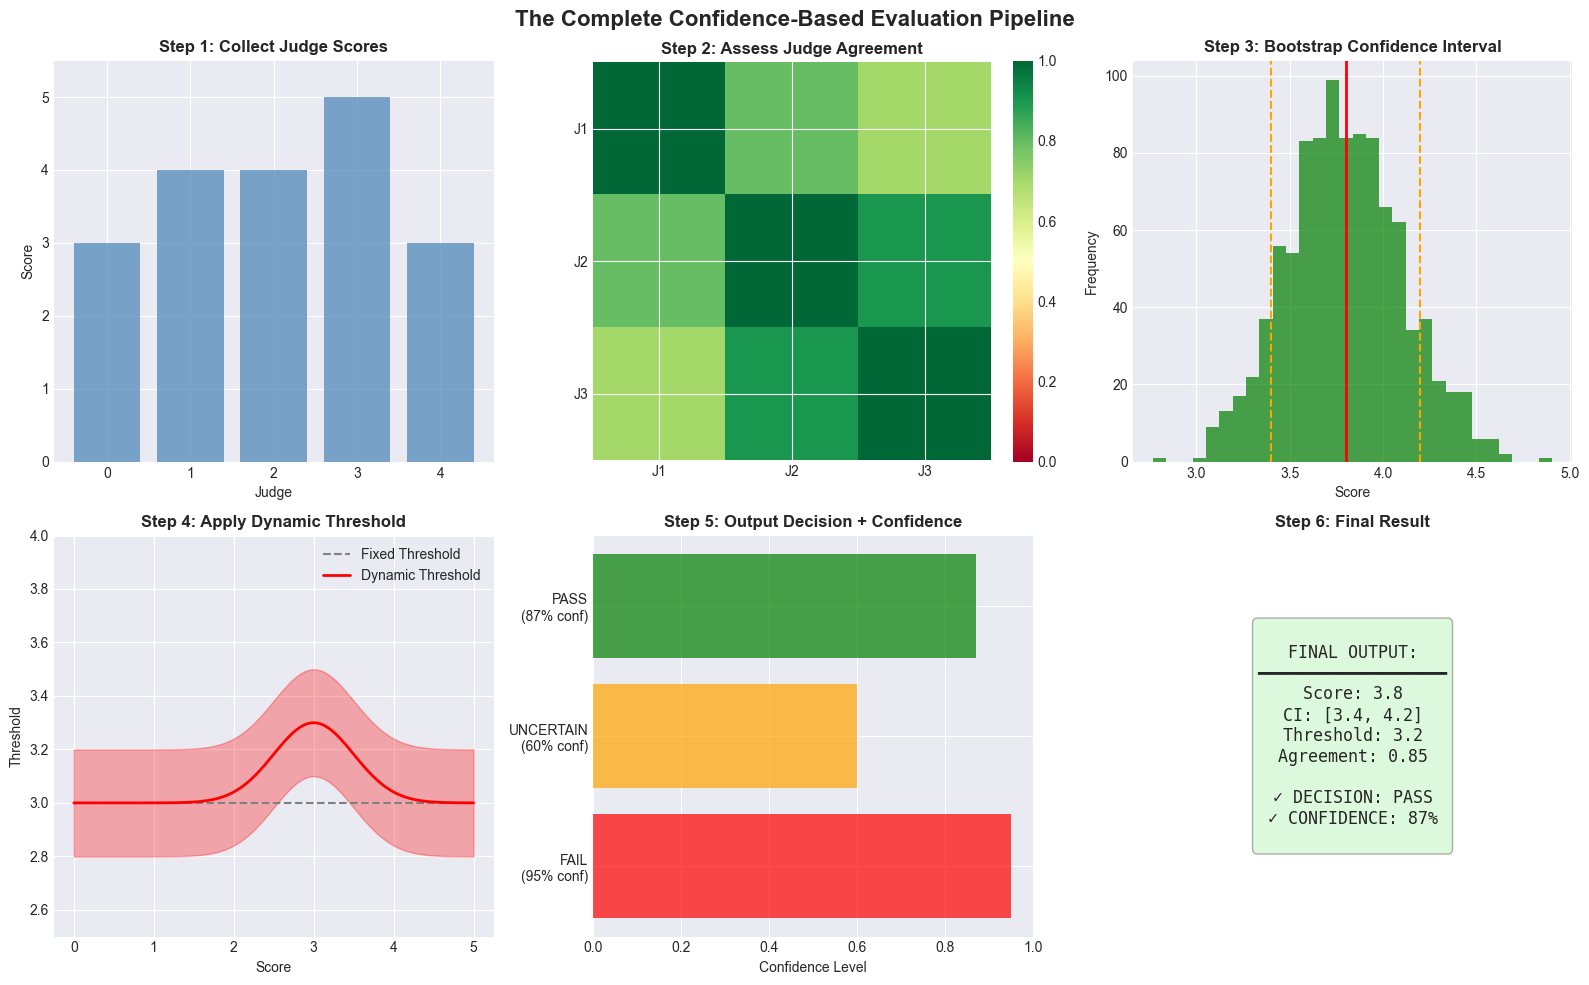


🎯 You now have a complete framework for confidence-based LLM evaluation!


In [41]:
# Create a visual summary of the entire process
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Raw Scores
ax1 = axes[0, 0]
example_scores = [3, 4, 4, 5, 3]
ax1.bar(range(len(example_scores)), example_scores, color='steelblue', alpha=0.7)
ax1.set_title('Step 1: Collect Judge Scores', fontweight='bold')
ax1.set_xlabel('Judge')
ax1.set_ylabel('Score')
ax1.set_ylim(0, 5.5)

# 2. Judge Agreement
ax2 = axes[0, 1]
agreement_matrix = np.array([[1.0, 0.8, 0.7], [0.8, 1.0, 0.9], [0.7, 0.9, 1.0]])
im = ax2.imshow(agreement_matrix, cmap='RdYlGn', vmin=0, vmax=1)
ax2.set_title('Step 2: Assess Judge Agreement', fontweight='bold')
ax2.set_xticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])
ax2.set_xticklabels(['J1', 'J2', 'J3'])
ax2.set_yticklabels(['J1', 'J2', 'J3'])
plt.colorbar(im, ax=ax2, fraction=0.046)

# 3. Bootstrap CI
ax3 = axes[0, 2]
bootstrap_means = np.random.normal(3.8, 0.3, 1000)
ax3.hist(bootstrap_means, bins=30, alpha=0.7, color='green')
ax3.axvline(x=3.8, color='red', linestyle='-', linewidth=2)
ax3.axvline(x=3.4, color='orange', linestyle='--')
ax3.axvline(x=4.2, color='orange', linestyle='--')
ax3.set_title('Step 3: Bootstrap Confidence Interval', fontweight='bold')
ax3.set_xlabel('Score')
ax3.set_ylabel('Frequency')

# 4. Dynamic Threshold
ax4 = axes[1, 0]
x = np.linspace(0, 5, 100)
base_threshold = np.ones_like(x) * 3
dynamic_threshold = 3 + 0.3 * np.exp(-((x - 3) ** 2) / 0.5)
ax4.plot(x, base_threshold, 'gray', linestyle='--', label='Fixed Threshold')
ax4.plot(x, dynamic_threshold, 'red', linewidth=2, label='Dynamic Threshold')
ax4.fill_between(x, dynamic_threshold - 0.2, dynamic_threshold + 0.2, alpha=0.3, color='red')
ax4.set_title('Step 4: Apply Dynamic Threshold', fontweight='bold')
ax4.set_xlabel('Score')
ax4.set_ylabel('Threshold')
ax4.legend()
ax4.set_ylim(2.5, 4)

# 5. Decision with Confidence
ax5 = axes[1, 1]
decisions = ['FAIL\n(95% conf)', 'UNCERTAIN\n(60% conf)', 'PASS\n(87% conf)']
colors_decision = ['red', 'orange', 'green']
y_pos = np.arange(len(decisions))
ax5.barh(y_pos, [0.95, 0.60, 0.87], color=colors_decision, alpha=0.7)
ax5.set_yticks(y_pos)
ax5.set_yticklabels(decisions)
ax5.set_xlabel('Confidence Level')
ax5.set_title('Step 5: Output Decision + Confidence', fontweight='bold')
ax5.set_xlim(0, 1)

# 6. Final Output
ax6 = axes[1, 2]
ax6.axis('off')
output_text = """
FINAL OUTPUT:
━━━━━━━━━━━━━━━━━━━
Score: 3.8
CI: [3.4, 4.2]
Threshold: 3.2
Agreement: 0.85

✓ DECISION: PASS
✓ CONFIDENCE: 87%
"""
ax6.text(0.5, 0.5, output_text, ha='center', va='center', fontsize=12, 
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
ax6.set_title('Step 6: Final Result', fontweight='bold')

plt.suptitle('The Complete Confidence-Based Evaluation Pipeline', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("\n🎯 You now have a complete framework for confidence-based LLM evaluation!")

---
## Key Takeaways
1. **Judge Disagreement is Normal**
   - Don't hide it, quantify it
   - Use it to inform confidence levels

2. **Confidence Intervals > Point Estimates**
   - A score of 3.8 ± 0.4 tells the whole story
   - Bootstrap methods work with small samples

3. **Dynamic Thresholds Prevent Errors**
   - High agreement → Lower threshold acceptable
   - Low agreement → Need higher scores for confidence

4. **Reliability Can Be Measured**
   - Track judge consistency
   - Weight reliable judges more heavily
   - Identify problematic metrics
---